# Exploratory Analysis & Sector Correlation Studies

## 1. Import Packages and Setup Config

In [7]:
import sqlite3
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Config
DB_PATH = "../data/data.db"
PRICES_CSV = "../data/processed/prices_daily.csv"
FEATURES_CSV = "../data/processed/features_daily.csv"
MACRO_CSV = "../data/processed/macro_daily.csv"

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

## 2. Load Data

In [8]:
def read_table(db_path: str, table: str, csv_fallback: str) -> pd.DataFrame:
    try:
        with sqlite3.connect(db_path) as conn:
            df = (pd.read_sql(f"SELECT * FROM {table}", conn, parse_dates=["date"])
                    .set_index("date")
                    .sort_index())
        print(f"Loaded '{table}' from SQLite DB at: {db_path}")
        return df
    except Exception as e:
        print(f"SQLite load failed for '{table}' ({e}); trying CSV fallback: {csv_fallback}")
        df = (pd.read_csv(csv_fallback, parse_dates=["date"])
                .set_index("date")
                .sort_index())
        print(f"Loaded '{table}' from CSV file at: {csv_fallback}")
        return df

prices = read_table(DB_PATH, "prices_daily", PRICES_CSV)
features = read_table(DB_PATH, "features_daily", FEATURES_CSV)
macro = read_table(DB_PATH, "macro_daily", MACRO_CSV)

prices.head(), features.head(), macro.head()


Loaded 'prices_daily' from SQLite DB at: ../data/data.db
Loaded 'features_daily' from SQLite DB at: ../data/data.db
Loaded 'macro_daily' from SQLite DB at: ../data/data.db


(                  XLF        XLK       XLE        XLV        XLI        XLP  \
 date                                                                          
 2000-01-03  11.147916  20.652027  6.699402  20.524776  18.125673  12.207152   
 2000-01-04  10.660572  19.604300  6.573297  20.059032  17.624903  11.863403   
 2000-01-05  10.576814  19.313269  6.746694  19.879076  17.546352  12.073006   
 2000-01-06  11.041308  18.672977  7.006786  19.942589  17.782000  12.299375   
 2000-01-07  11.224064  18.998943  7.081664  20.186047  18.459505  13.079085   
 
                   XLY       XLB       XLU        SPY  
 date                                                  
 2000-01-03  11.173430  7.260402  5.551600  91.617004  
 2000-01-04  10.837304  7.190506  5.384137  88.034286  
 2000-01-05  10.704014  7.487561  5.520001  88.191765  
 2000-01-06  10.825711  7.679779  5.510525  86.774384  
 2000-01-07  11.335704  7.675406  5.557919  91.813896  ,
              XLF_r1d   XLK_r1d   XLE_r1d   X

## 3. Daily Return by Sector

,count,mean,std,min,25%,50%,75%,max
XLF,6453.0,0.0004,0.0181,-0.1667,-0.0066,0.0006,0.0078,0.1646
XLK,6453.0,0.0004,0.0163,-0.1381,-0.0066,0.0010,0.0079,0.1610
XLE,6453.0,0.0005,0.0183,-0.2014,-0.0083,0.0007,0.0098,0.1647
XLV,6453.0,0.0004,0.0112,-0.0986,-0.0050,0.0006,0.0062,0.1205
XLI,6453.0,0.0004,0.0134,-0.1134,-0.0057,0.0008,0.0070,0.1265
XLP,6453.0,0.0003,0.0094,-0.0940,-0.0043,0.0005,0.0052,0.0851
XLY,6453.0,0.0005,0.0144,-0.1267,-0.0060,0.0009,0.0076,0.1089
XLB,6453.0,0.0004,0.0150,-0.1241,-0.0070,0.0008,0.0082,0.1406
XLU,6453.0,0.0004,0.0122,-0.1136,-0.0054,0.0009,0.0067,0.1279
SPY,6453.0,0.0004,0.0123,-0.1094,-0.0046,0.0007,0.0060,0.1452


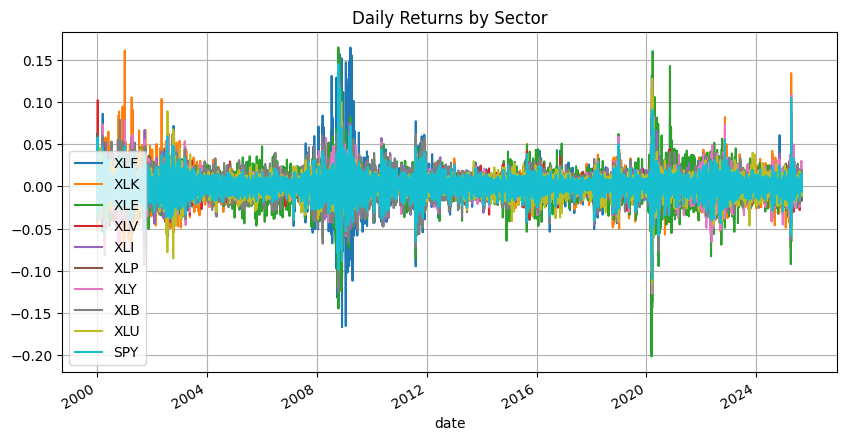

In [9]:
# Daily Return by Sector
returns = prices.pct_change()
display(returns.describe().T.round(4))
# Plot a subset (or all) of sector return series
returns.plot(title="Daily Returns by Sector")
plt.show()

The plot shows that most U.S. sector ETFs move closely together, indicating strong market-wide correlation driven by common factors. Defensive sectors such as XLU and Consumer Staples (XLP) exhibit the smallest fluctuations, while cyclical sectors like Energy (XLE) and Technology (XLK) show larger swings, reflecting higher sensitivity to macroeconomic changes. 

The sharp drop and rebound around 2020 correspond to the COVID-19 crash and recovery, while the increased amplitude of returns after 2021 highlights the volatility during the inflation and rate-hike period. 

Overall, SPY tracks near the sector average, confirming its role as the broad market benchmark.

## 4. Sector Correlation

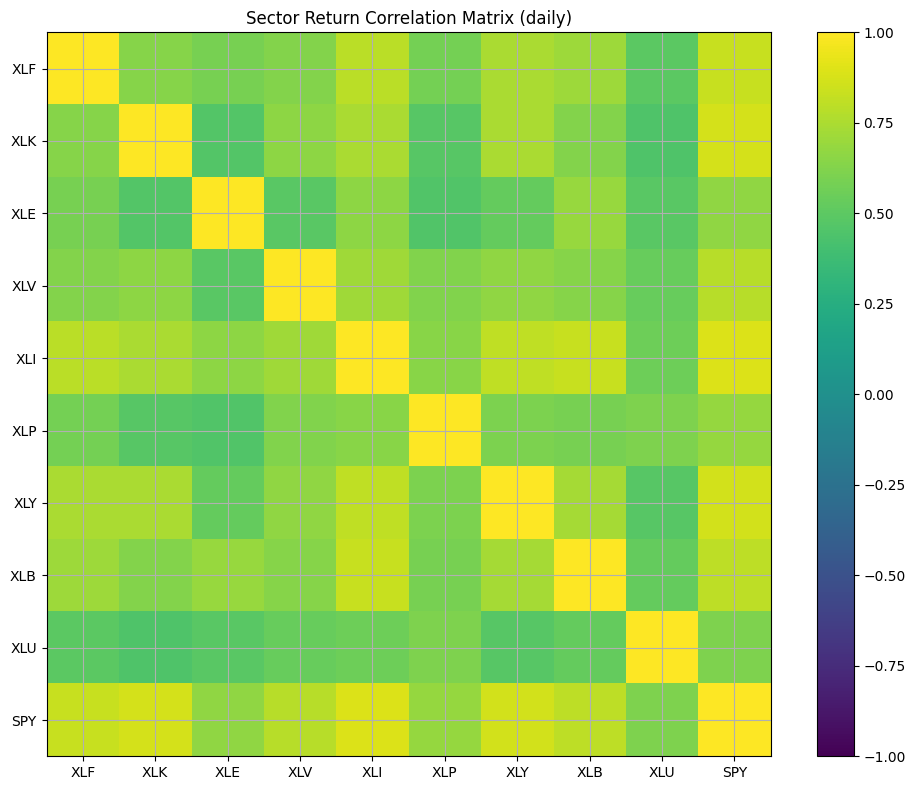

In [10]:
corr = returns.corr()

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr.values, vmin=-1, vmax=1)
ax.set_title("Sector Return Correlation Matrix (daily)")
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.index)))
ax.set_xticklabels(corr.columns)
ax.set_yticklabels(corr.index)
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

This correlation matrix shows that nearly all sectors have strong positive correlations with each other, generally ranging between 0.5 and 0.9, which reflects the broad market’s tendency to move in unison. 

The bright yellow cells along the off-diagonal indicate particularly high correlations (e.g., between Technology [XLK], Consumer Discretionary [XLY], and Financials [XLF]), all of which are cyclical sectors that respond similarly to economic growth. Conversely, cooler green-blueareas such as those involving Energy [XLE] or Utilities [XLU] indicate weaker correlations, suggesting these sectors behave somewhat independently—Energy often diverges due to commodity price shocks, and Utilities act as a defensive hedge. 

SPY, as expected, is highly correlated with all sectors since it represents the aggregate market. Overall, the matrix confirms that sector performance is heavily synchronized, with only a few defensive or commodity-linked exceptions providing diversification.